# Song Recommendations

In [1]:
from itertools import combinations
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

from tqdm import tqdm

import networkx as nx

import torch
import torch.tensor as t

In [2]:
data = pd.read_csv('https://s3.amazonaws.com/dato-datasets/millionsong/10000.txt', sep='\t', names=['user_id', 'song_id', 'listen_count'], header=None)

In [3]:
data.head(5)

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


## Modeling Songs Graphically

So our goal is to use a graphical, Markov Chain type approach on this data. This general idea is as follows.  First, we'll need to convert our dataset into a comparisons type format, because each edge on our graph wil represent the strength of preferences between two nodes which represent songs. Clearly we're initializing the graph as complete, which is not particularly efficient, but just wait there is an idea.  

However, starting with a complete graph means that we're really not getting any benefits of the graphical approach.  Recall, graphs allow us to express independencies.  It means that we can claim that two songs *don't influence each other*, and thus we can simplify the model by removing the edge between those songs.  

To demonstrate what I mean, let's look at a simple case with just 5 songs.

D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


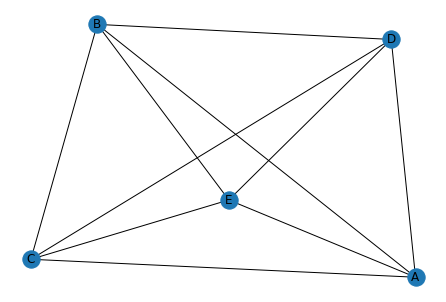

In [4]:
# This is a complete graph.  There is no difference between this a table. 
nodes = ['A', 'B', 'C', 'D', 'E']
graph = nx.Graph()
allcombinations = list(combinations(nodes, 2))
graph.add_edges_from(allcombinations)
nx.draw(graph, with_labels=True)

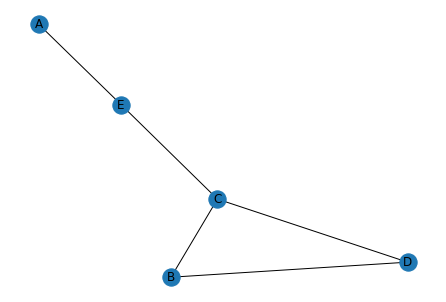

In [5]:
# By removing many edges, the relationships between songs is much clearer and can more directly inform the prediction.
sorted_sample = [
    allcombinations[i] for i in sorted(random.sample(range(len(allcombinations)), 5))
]
simpler_graph = nx.Graph()
simpler_graph.add_edges_from(sorted_sample)
nx.draw(simpler_graph, with_labels=True)

## Getting to a Trimmed Graph

There are a few different known approaches to building graphs.  You can either:

* Start with complete graph and remove edges such that its predictions improve along some metric.  You might decide which edges to prune by examining the current strength of that edge, where weak edges would be likely to be eliminated.
* Start with a sparse graph and add edges in a similar faschion.
* Randomly try different graphs and hope you get lucky!

Thinking about the logic of the Laplacian correction (that even if we haven't seen an event, we should assign a small probability to it), I like the idea that you at least start with at least a small probability of going to adjacent nodes. However at some stage we should trim sets of edges with extremely low probability. 

## Data Preparation for Model Prototyping

My goal is to be able to process our data a record at a time and update the graph, ideally in a way that could be easily parallelized.  Ideally this means that we don't have to transform our data into a comparison table or anything like that, instead we can just take a set of user records and update the graph. We'll start by just trying to get a graph from a single users data. 

In [113]:
class GraphicalSongRecommender(object):
    def __init__(self):
        self.graph_ = nx.Graph()
        self.rank_ = None

    def process_user(self, userdata):
        """
        Process a single user's records into a graph.  We'll later combine this graph
        with our graph of all songs. 
        """
        user_graph = nx.Graph()
        visited = []
        for ix, row in userdata.iterrows():
            song, listens = row['song_id'], row['listen_count']
            user_graph.add_node(song, listen_count=listens)
            for v in visited:
                combined = user_graph.nodes[v]['listen_count'] + user_graph.nodes[song]['listen_count']
                user_graph.add_edge(v, song, listen_count=combined)
            visited.append(song)
        return user_graph
    
    def graph_sum(self, user_graph):
        """
        Combines a single user_graph with the total_user graph.
        """
        # Make sure all nodes in user_graph are in total_user graph
        for node in user_graph.nodes:
            if node not in self.graph_.nodes:
                self.graph_.add_node(node, listen_count=0)
            self.graph_.nodes[node]['listen_count'] += user_graph.nodes[node]['listen_count']
        for edge in user_graph.edges:
            if edge not in self.graph_.edges:
                self.graph_.add_edges_from([edge], listen_count=0)
            self.graph_.edges[edge]['listen_count'] += user_graph.edges[edge]['listen_count']
    
    def calculate_rank(self):
        self.rank_ = nx.pagerank(self.graph_, weight='listen_count')
    
    
    
    def write_graph(self):
        nx.write_gpickle(recommender.graph_, 'graph.pkl')
        
    def load_graph(self):
        self.graph_ = nx.read_gpickle('graph.pkl')
        
    def display(self, labels=False):
        nx.draw(self.graph_, with_labels=labels)

In [114]:
data.user_id.sample(5)

1011709    0226e04b72ef6ec36050cf0f548d09f947a5c251
644984     6975b817a4158409ac0195558cb19d19411731c3
244310     2b8a13faee3d44ddd2d43254a2071e7c90d205d9
1947480    fc0fe330e22830ce913ad547724f13ac79ac98c3
814239     ed02a1aad6a1e982d6d2ea9b77b2d6f14dadd2d1
Name: user_id, dtype: object

In [175]:
recommender = GraphicalSongRecommender()

sample_size = len(data.user_id.unique())
sampled = data[data.user_id.isin(data.user_id.sample(sample_size))]
for user in tqdm(sampled.user_id.unique()):
    userdata = sampled[sampled.user_id == user]
    usergraph = recommender.process_user(userdata)
    recommender.graph_sum(usergraph)
#recommender.display()



  0%|                                                | 0/38079 [00:00<?, ?it/s]

  0%|                                        | 2/38079 [00:00<58:23, 10.87it/s]

  0%|                                        | 4/38079 [00:00<59:14, 10.71it/s]

  0%|                                      | 5/38079 [00:00<1:06:58,  9.47it/s]

  0%|                                      | 6/38079 [00:00<1:05:55,  9.63it/s]

  0%|                                      | 7/38079 [00:01<2:57:40,  3.57it/s]

  0%|                                      | 8/38079 [00:01<2:30:04,  4.23it/s]

  0%|                                     | 10/38079 [00:01<2:01:53,  5.21it/s]

  0%|                                     | 11/38079 [00:01<1:52:55,  5.62it/s]

  0%|                                     | 13/38079 [00:01<1:35:41,  6.63it/s]

  0%|                                     | 15/38079 [00:02<1:23:38,  7.59it/s]

  0%|                                     | 16/38079 [00:02<1:31:50,  6.91it/s]

  0%|                     

In [176]:
# It takes an estimated 45 second to complete 1000 users from our data...
# Therefore it'll take approximately:
print(f"Expected Runtime: {(len(data.user_id.unique()) * ((8*60+23)/10000)) / 60} min")

Expected Runtime: 64.009265 min


In [177]:
# Once we have the data, we better be able to save it. 
recommender.write_graph()

In [118]:
recommender.load_graph()

In [178]:
# How many edges we have
len(recommender.graph_.edges)

20289377

In [179]:
# The Worst Case number of edges.  The good news is we're doing much better than this. 
len(recommender.graph_.nodes)**2

100000000

Given our matrix, how might we then turn that into something we can actually use for ranking?  NetworkX's `google_matrix` algorithm will transform our graph into a kind of normalized laplacian.  Each row can in turn be used as transition probabilities in the PageRank algorithm.  

In [138]:
mat = nx.google_matrix(recommender.graph_, weight="listen_count")

Or we can just directly calculate the PageRank.

In [180]:
recommender.calculate_rank()

AttributeError: 'GraphicalSongRecommender' object has no attribute 'calculate_rank'

# Making recommendations using PageRank

PageRank should enable us to choose the best recommendations given a song.  We'll start be just checking out that songs edges and nodes with the highest PageRank. 

In [174]:
testsong = data.song_id.sample(1).iloc[0]
def recommend_from_song(id):
    ranked = pd.DataFrame([{'song': song, 'rank': rank[song]} for song in recommender.graph_.neighbors(id)])
    return ranked.sort_values('rank', ascending=False).iloc[:15, :]
    
recommend_from_song(testsong)

,rank,song
619,0.002890,SOBONKR12A58A7A7E0
617,0.002646,SOAUWYT12A81C206F1
405,0.002624,SOAXGDH12A8C13F8A1
608,0.002402,SOSXLTC12AF72A7F54
437,0.002394,SOFRQTD12A81C233C0
642,0.002049,SOPUCYA12A8C13A694
479,0.002033,SONYKOW12AB01849C9
623,0.002015,SOEGIYH12A6D4FC0E3
523,0.001656,SOWCKVR12A8C142411
610,0.001536,SOUFTBI12AB0183F65
